Found 935 images belonging to 3 classes.
Found 232 images belonging to 3 classes.
Epoch 1/25
30/30 [==============================] - ETA: 0s - loss: 0.4845 - accuracy: 0.8043
Epoch 1: val_loss improved from inf to 2.68112, saving model to logs/best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


30/30 [==============================] - 74s 2s/step - loss: 0.4845 - accuracy: 0.8043 - val_loss: 2.6811 - val_accuracy: 0.8621 - lr: 0.0010
Epoch 2/25
30/30 [==============================] - ETA: 0s - loss: 0.3414 - accuracy: 0.9048
Epoch 2: val_loss did not improve from 2.68112
30/30 [==============================] - 37s 1s/step - loss: 0.3414 - accuracy: 0.9048 - val_loss: 3.7060 - val_accuracy: 0.7888 - lr: 0.0010
Epoch 3/25
30/30 [==============================] - ETA: 0s - loss: 0.1856 - accuracy: 0.9380
Epoch 3: val_loss improved from 2.68112 to 1.06487, saving model to logs/best_model.h5
30/30 [==============================] - 40s 1s/step - loss: 0.1856 - accuracy: 0.9380 - val_loss: 1.0649 - val_accuracy: 0.9353 - lr: 0.0010
Epoch 4/25
30/30 [==============================] - ETA: 0s - loss: 0.2563 - accuracy: 0.9230
Epoch 4: val_loss did not improve from 1.06487
30/30 [==============================] - 38s 1s/step - loss: 0.2563 - accuracy: 0.9230 - val_loss: 1.7592 - val

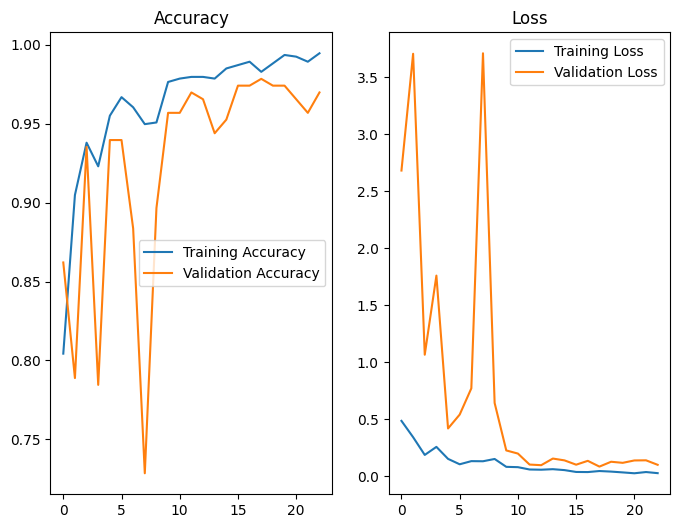

8/8 [==============================] - 6s 688ms/step - loss: 0.1225 - accuracy: 0.9698
Test accuracy: 96.98%
8/8 [==============================] - 5s 533ms/step
[[25 29 22]
 [25 29 24]
 [27 20 31]]


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [29]:
from tensorflow import keras
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten
from tensorflow.keras.applications import Xception
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Load the dataset
data_dir = "/content/drive/MyDrive/train"

# Define the number of classes
num_classes = 3

# Create the data generator
datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=0.15,
    vertical_flip=0.15,
    validation_split=0.2
)

# Generate the training data
train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(256, 256),
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical",
    subset='training'
)

# Generate the validation data
val_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(256, 256),
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical",
    subset='validation'
)

# Build the Xception model
base_model = Xception(
    include_top=False,
    input_shape=(256, 256, 3),
    pooling="avg"
)
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation="softmax")(x)
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(
    loss="categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

# Define callbacks
log_folder = 'logs'
checkpoint = ModelCheckpoint(
    os.path.join(log_folder, 'best_model.h5'),
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    verbose=1
)
tensorboard_callback = TensorBoard(
    log_dir=log_folder,
    histogram_freq=1
)

# Train the model
history = model.fit(
    train_generator,
    epochs=25,
    validation_data=val_generator,
    callbacks=[checkpoint, early_stopping, reduce_lr, tensorboard_callback]
)

# Plot the training and validation accuracy and loss
plt.figure(figsize=(8, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.show()

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(val_generator)
print("Test accuracy: {:.2%}".format(test_acc))

# Make predictions on the test set
test_preds = model.predict(val_generator)
test_labels = np.argmax(test_preds, axis=-1)

# Print the confusion matrix
conf_mat = confusion_matrix(test_labels, val_generator.classes)
print(conf_mat)

# Save the trained model
model.save("/path/to/save/trained_model.hdf5")